In [1]:
from game import Game
#import cppchess as chess
#from mcts.c import run_mcts
import chess
from mcts import run_mcts
from config import Config
import tensorflow as tf
from trt_funcs import load_trt_model


#model_path = f"./saved_model"
#model_path = f"models/test/saved_model"
#model_path = "train/checkpoints/trt/11-03-2024_10:55:58/saved_model"
#model_path = "./saved_model"
model_path = "train/checkpoints/trt/12-03-2024_05:52:18"
trt_func, model = load_trt_model(model_path)
config = Config()

game = Game(chess.Board())

2024-03-12 06:41:49.157897: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-12 06:41:50.671487: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5608 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:26:00.0, compute capability: 7.5
2024-03-12 06:41:51.440671: E tensorflow/compiler/tf2tensorrt/utils/trt_logger.cc:87] DefaultLogger 3: [runtime.cpp::~Runtime::346] Error Code 3: API Usage Error (Parameter check failed at: runtime/rt/runtime.cpp::~Runtime::346, condition: mEngineCounter.use_count() == 1. Destroying a runtime before destroying deserialized engines created by the runtime leads to undefined behavior.
)


Time taken: 3.19s
Visits: 1600
Summed value: 656.055037
Evaluation: 0.845620
Best variation: e8d8 -> h4g5 -> d8e8 -> e1d1 -> e8d8 -> d1e1 -> d8e8 -> e1f1 -> f8h8
Move          Visits  NN Output                    Policy             Prior          Avg. value     UCB            Q+U           
----------------------------------------------------------------------------------------------------------------------------------
e8d8  (2342)  N: 374  (v: 0.701045, p:  12.549274)  (p_norm:  24.80%)  (P: 0.248032)  (Q: 0.587357)  (U: 0.643566)  (Q+U: 1.230923)
f7f6  (2993)  N: 194  (v: 0.701219, p:  10.500242)  (p_norm:   3.20%)  (P: 0.031961)  (Q: 0.628075)  (U: 0.642004)  (Q+U: 1.270079)
g4f2  (3853)  N: 146  (v: 0.709746, p:  10.023849)  (p_norm:   1.98%)  (P: 0.019849)  (Q: 0.631514)  (U: 0.642989)  (Q+U: 1.274504)
g4e3  (3858)  N: 131  (v: 0.663343, p:  9.940940)  (p_norm:   1.83%)  (P: 0.018269)  (Q: 0.630107)  (U: 0.641869)  (Q+U: 1.271976)
a7a8  (77  )  N: 106  (v: 0.701182, p:  9.614018) 

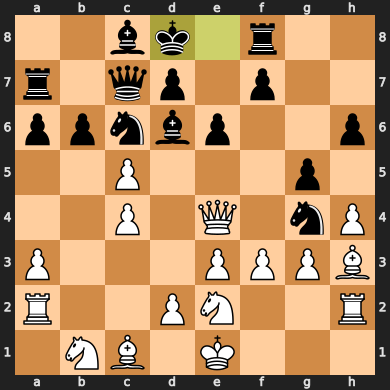

In [41]:
move, root = run_mcts(
    config,
    game,
    trt_func,
    None,
    False,
    1600,
    0,
    False,
    (1.6, 1.25),
    verbose_move=True,
)
game.make_move(move)
game.board

In [1]:
%load_ext cython

In [2]:
%%cython --compile-args=-w
import numpy as np
cimport numpy as np
cimport cython
from gameimage.c cimport board_to_image, update_image, convert_to_model_input
from config import Config
import cppchess as chess
from game import Game
from tf_funcs import predict_fn
from actionspace import map_w, map_b
from libc.math cimport log, exp


cdef class Node:
    cdef int N
    cdef float P
    cdef float W
    cdef float fpu
    cdef dict children
    cdef np.ndarray image

    def __init__(self, P=0.0, fpu=0.0):
        self.N = 0
        self.P = P
        self.W = 0.0
        self.fpu = fpu
        self.children = {}
        self.image = None

    def __cinit__(self, float P=0.0, float fpu=0.0):
        self.N = 0
        self.P = P
        self.W = 0.0
        self.fpu = fpu
        self.children = {}
        self.image = None

    @property
    def Q(self):
        return self.W / (self.N) if self.N > 0 else self.fpu

    @property
    def is_leaf(self):
        return len(self.children) == 0

    @property
    def P(self):
        return self.P

    @P.setter
    def P(self, value):
        self.P = value

    @property
    def N(self):
        return self.N

    @N.setter
    def N(self, value):
        self.N = value

    @property
    def W(self):
        return self.W

    @W.setter
    def W(self, value):
        self.W = value

    @property
    def image(self):
        return self.image

    @image.setter
    def image(self, value):
        self.image = value

    def add_child(self, move, P, fpu):
        self.children[move] = Node(P, fpu)

cdef class MCTS:
    # Search properties
    cdef object rng
    cdef Node root
    cdef object game
    cdef object network
    cdef bint selfplay

    # MCTS constants
    cdef float pb_c_base, pb_c_init
    cdef float pb_c_factor_root, pb_c_factor_leaf,
    cdef float policy_temp, softmax_temp
    cdef float fpu_root, fpu_leaf
    cdef float dirichlet_alpha, exploration_fraction
    cdef int num_sampling_moves

    def __init__(self, config, game, network, selfplay=False):
        self.root = Node()
        self.game = game
        self.network = network
        self.selfplay = selfplay
        self.rng = np.random.default_rng()

        self.pb_c_base = config.pb_c_base
        self.pb_c_init = config.pb_c_init
        self.pb_c_factor_root = config.pb_c_factor[0]
        self.pb_c_factor_leaf = config.pb_c_factor[1]
        self.policy_temp = config.policy_temp
        self.softmax_temp = config.softmax_temp
        self.fpu_root = config.fpu_root
        self.fpu_leaf = config.fpu_leaf
        self.dirichlet_alpha = config.root_dirichlet_alpha
        self.exploration_fraction = config.root_exploration_fraction
        self.num_sampling_moves = config.num_mcts_sampling_moves


    def __cinit__(self, config, game, network, selfplay=False):
        self.root = Node()
        self.game = game
        self.network = network
        self.selfplay = selfplay
        self.rng = np.random.default_rng()

        self.pb_c_base = config.pb_c_base
        self.pb_c_init = config.pb_c_init
        self.pb_c_factor_root = config.pb_c_factor[0]
        self.pb_c_factor_leaf = config.pb_c_factor[1]
        self.policy_temp = config.policy_temp
        self.softmax_temp = config.softmax_temp
        self.fpu_root = config.fpu_root
        self.fpu_leaf = config.fpu_leaf
        self.dirichlet_alpha = config.root_dirichlet_alpha
        self.exploration_fraction = config.root_exploration_fraction
        self.num_sampling_moves = config.num_mcts_sampling_moves


    cdef select(self, Node node, float pb_c_factor):
        cdef str move
        cdef str bestmove
        cdef float ucb
        cdef float bestucb = -np.inf
        cdef object child
        cdef object bestchild

        for move, child in node.children.items():
            if pb_c_factor > 0.0:
                ucb = child.Q + self.UCB(child.P, child.N, node.N, pb_c_factor)
            else:
                ucb = child.Q
            if ucb > bestucb:
                bestucb = ucb
                bestmove = move
                bestchild = child

        return bestmove, bestchild

    cdef float UCB(self, float cP, int cN, int pN, float pb_c_factor):
        cdef float cpuct
        cpuct = (
            log((pN + self.pb_c_base + 1) / self.pb_c_base) + self.pb_c_init
        ) * pb_c_factor
        return cpuct * cP * pN**0.5 / (cN + 1)

    cdef select_move(self, Node node, float softmax_temp = 0.0):
        moves = [move for move in node.children.keys()]
        visit_counts = [child.N for child in node.children.values()]
        if softmax_temp == 0.0:
            # Greedy selection (select the move with the highest visit count) 
            # If more moves have the same visit count, choose one randomly
            return moves[self.rng.choice(np.flatnonzero(visit_counts == np.max(visit_counts)))]
        else:
            # Use the visit counts as a probability distribution to select a move
            pi = np.array(visit_counts) ** (1 / softmax_temp)
            pi /= np.sum(pi)
            return moves[np.where(self.rng.multinomial(1, pi) == 1)[0][0]]

    cdef void expand(self, Node node, game, float[:] policy_logits, float fpu):
        cdef list policy = []
        cdef list moves = []
        cdef np.ndarray[double, ndim=1] policy_np
        cdef bint to_play = game.to_play()
        cdef object move
        cdef str move_uci
        cdef int action
        cdef float p
        cdef float _max
        cdef float expsum

        for move in game.board.legal_moves: # Acces via generator for speedup
            move_uci = move.uci()
            action = map_w[move_uci] if to_play else map_b[move_uci]
            moves.append(move_uci)
            policy.append(policy_logits[action])

        policy_np = np.array(policy)
        _max = policy_np.max()
        expsum = np.sum(np.exp(policy_np - _max))
        policy_np = np.exp(policy_np - (_max + np.log(expsum)))
        if self.policy_temp > 0.0 and self.policy_temp != 1.0:
            policy_np = policy_np ** (1.0 / self.policy_temp)
            policy_np /= np.sum(policy_np) 

        for move_uci, p in zip(moves, policy_np):
            node.add_child(move_uci, p, fpu)

    cdef void backup(self, list search_path, float value):
        for node in search_path:
            node.N += 1
            node.W += value
            value = flip_value(value)

    cpdef str run(self, int num_simulations):
        if self.root.is_leaf:
            if self.root.image is None:
                self.root.image = board_to_image(self.game.board)
            _, policy_logits = make_predictions(self.network, self.root.image)
            self.expand(self.root, self.game, policy_logits, self.fpu_root)

        if self.selfplay:
            self.add_exploration_noise(self.root)

        for _ in xrange(num_simulations):
            node = self.root
            search_path = [node]
            tmp_game = self.game.clone()
            while not node.is_leaf:
                pb_c_factor = self.pb_c_factor_root if len(search_path) == 1 else self.pb_c_factor_leaf
                move, node = self.select(node, pb_c_factor)
                tmp_game.make_move(move)
                search_path.append(node)

            value, terminal = evaluate(tmp_game)
            if not terminal:
                parent = search_path[-2]
                node.image = update_image(tmp_game.board, parent.image)
                value, policy_logits = make_predictions(self.network, node.image)
                self.expand(node, tmp_game, policy_logits, self.fpu_leaf)
            
            self.backup(search_path, flip_value(value))

        return self.select_move(self.root, self.softmax_temp if self.game.history_len < self.num_sampling_moves else 0.0)


    cdef void add_exploration_noise(self, Node node):
        noise = self.rng.gamma(self.dirichlet_alpha, 1, len(node.children))
        noise /= noise.sum()
        for n, child in zip(noise, node.children.values()):
            child.P = child.P * (1 - self.exploration_fraction) + n * self.exploration_fraction

cdef make_predictions(object network, np.ndarray image):
    value, policy_logits = predict_fn(network, convert_to_model_input(image))
    value = value.numpy().item()
    policy_logits = policy_logits.numpy().flatten()
    return value_to_01(value), policy_logits
        
cdef evaluate(game):
    if game.terminal_with_outcome():
        return value_to_01(game.terminal_value(game.to_play())), True
    else:
        return value_to_01(0.0), False

cdef inline float value_to_01(float value):
    return (value + 1) / 2

cdef inline float flip_value(float value):
    return 1-value


from trt_funcs import load_trt_model
from time import time

config = Config()
game = Game(chess.Board())
trt_func, model = load_trt_model("train/checkpoints/trt/12-03-2024_05:52:18")
mcts = MCTS(config, game, trt_func, False)

times = []
for i in range(100):
    t1 = time()
    move = mcts.run(600)
    t2 = time()
    times.append(t2-t1)

print(f"Average time: {np.mean(times)}")
print(f"Total time: {np.sum(times)}")

""" node = Node()
print(node.Q()) """

2024-03-12 12:30:05.822188: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-12 12:30:07.344745: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6137 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:26:00.0, compute capability: 7.5
2024-03-12 12:30:08.118841: E tensorflow/compiler/tf2tensorrt/utils/trt_logger.cc:87] DefaultLogger 3: [runtime.cpp::~Runtime::346] Error Code 3: API Usage Error (Parameter check failed at: runtime/rt/runtime.cpp::~Runtime::346, condition: mEngineCounter.use_count() == 1. Destroying a runtime before destroying deserialized engines created by the runtime leads to undefined behavior.
)


Average time: 0.5316031217575073
Total time: 53.16031217575073


In [1]:
from game import Game
from mcts.c import run_mcts
from config import Config
import cppchess as chess
from time import time
import numpy as np
from trt_funcs import load_trt_model

config = Config()
game = Game(chess.Board())
trt_func, model = load_trt_model("train/checkpoints/trt/12-03-2024_05:52:18")

times = []

for i in range(100):
    t1 = time()
    move, root = run_mcts(
        config,
        game,
        trt_func,
        None,
        False,
        100,
        0,
        False,
        (1.6, 1.35),
    )
    t2 = time()
    times.append(t2-t1)
print(move)
print(f"Average time: {np.mean(times)}")
print(f"Total time: {np.sum(times)}")

    

2024-03-12 14:20:51.220686: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-12 14:20:52.741443: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5851 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:26:00.0, compute capability: 7.5
2024-03-12 14:20:53.557215: E tensorflow/compiler/tf2tensorrt/utils/trt_logger.cc:87] DefaultLogger 3: [runtime.cpp::~Runtime::346] Error Code 3: API Usage Error (Parameter check failed at: runtime/rt/runtime.cpp::~Runtime::346, condition: mEngineCounter.use_count() == 1. Destroying a runtime before destroying deserialized engines created by the runtime leads to undefined behavior.
)


f2f3
Average time: 0.10538718700408936
Total time: 10.538718700408936


In [1]:
from game import Game
from mcts2.c import MCTS
from config import Config
import cppchess as chess
from time import time
import numpy as np
from trt_funcs import load_trt_model

config = Config()
game = Game(chess.Board())
trt_func, model = load_trt_model("train/checkpoints/trt/12-03-2024_05:52:18")
mcts = MCTS(config, game, trt_func, False)

times = []
for i in range(100):
    t1 = time()
    move = mcts.run(100)
    t2 = time()
    mcts.reset()
    times.append(t2-t1)

print(move)
print(f"Average time: {np.mean(times)}")
print(f"Total time: {np.sum(times)}")

2024-03-12 14:25:14.246190: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-12 14:25:15.740871: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5956 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:26:00.0, compute capability: 7.5
2024-03-12 14:25:16.532964: E tensorflow/compiler/tf2tensorrt/utils/trt_logger.cc:87] DefaultLogger 3: [runtime.cpp::~Runtime::346] Error Code 3: API Usage Error (Parameter check failed at: runtime/rt/runtime.cpp::~Runtime::346, condition: mEngineCounter.use_count() == 1. Destroying a runtime before destroying deserialized engines created by the runtime leads to undefined behavior.
)


Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing...
Cache probing.

In [5]:
from pympler import asizeof
asizeof.asizeof(mcts.root)

72

In [2]:
for move, node in mcts.root.children.items():
    print(move, node.N, node.W, node.P)

g1h3 409 219.0319061279297 0.0585554763674736
g1f3 318 161.2613525390625 0.07946397364139557
b1c3 291 150.92831420898438 0.059846822172403336
b1a3 261 134.6919708251953 0.056107744574546814
h2h3 507 281.2758483886719 0.03558826446533203
g2g3 158 78.18299102783203 0.04694308713078499
f2f3 241 115.48038482666016 0.08558370172977448
e2e3 3661 2087.931884765625 0.05311548709869385
d2d3 114 56.44194030761719 0.03364751115441322
c2c3 315 161.4060821533203 0.07253221422433853
b2b3 269 142.49322509765625 0.04448965936899185
a2a3 711 396.8294677734375 0.04080924764275551
h2h4 406 223.23049926757812 0.03580116480588913
g2g4 216 110.9552993774414 0.04891226440668106
f2f4 201 99.54315948486328 0.0592736080288887
e2e4 676 376.95904541015625 0.040078841149806976
d2d4 169 89.5067367553711 0.02797381393611431
c2c4 630 349.8011169433594 0.043057698756456375
b2b4 241 127.63319396972656 0.039806608110666275
a2a4 206 107.94853210449219 0.03841280937194824


In [4]:
image = root.image

In [9]:
print(image.tobytes())

b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x

In [25]:
print(hash(image.tobytes()))
type(hash(image.tobytes()))

343602914293504513


int

In [20]:
from time import time
cache = {
    hash(image.tobytes()): [0.5, np.random.rand(4672)]
}
times = []
for i in range(1000):
    t1=time()
    h = hash(image.tobytes())
    if h in cache:
        h = cache[h]
    t2=time()
    times.append(t2-t1)
print(f"Average time: {np.mean(times)}")
print(f"Total time: {np.sum(times)}")

Average time: 5.798816680908203e-06
Total time: 0.005798816680908203


In [26]:
import pympler
pympler.asizeof.asizeof(cache) / 1024

18.9921875

In [27]:
1024 //19

53